# <center> <h3> Package "CV-bounds" </h3> </center>
## <center> Ning XU </center>


In this Jupyter notebook, we demonstrate the Python package "CVbounds", which is designed to compute the upper bound for the average test error of each potential model in the lasso algorithm.

The package is coded in Python (version 3.6.2) using NumPy (version 1.13.1), Matplotlib (version 2.0.2) and Scikit-learn (version 0.19.0). In replications, we use numpy.random.random to fix random seeds manually.

CVbounds contains a specific composite function to compute the Rademacher complexity of the regression model in several steps. First, we sample $n$ i.i.d.  observations for $p$ covariates, returning the sample of $X$. Next, we simulate $n$ i.i.d.  observations of the Rademacher variable, which is independent from the covariates. Then, we perform the lasso regression of $X$ on the Rademacher variable, compute the predicted values and calculate the correlation between the predicted values and the true values of the Rademacher variable. Since OLS maximizes the correlation between the predicted values and the response variable, to compute the Rademacher complexity, we just need to compute the OLS regression of $X$ on $\omega$. Lastly, we integrate out the Rademacher variable and all $p$ covariates, returning the Rademacher complexity of the regression model. To simplify the calculations, we choose $X$ to be multivariate Gaussian. Were the exact distribution of $X$ unknown a priori, bootstrapping or MCMC could be used to approximate the population distribution.

In empirical studies of statistical learning for small datasets, training-validation splits of $\left( 0.5, 0.5 \right)$, $\left( 0.66, 0.33 \right)$ or $\left( 0.8, 0.2 \right)$---$K = 2$, $3$, or $5$---outperform other splitting schemes. The \texttt{CVbounds} package may be extended to $K = 3 $ (or $5$) by adding an extra Python function to estimate $V_K \left[ T_q \right]$ via boostrapping or MCMC. The drawback is that a larger $K$ will increase the variance of the CV error.

## This is the code to generate Figure 3.

## Attention:

* This file only contains supplementray explanation about the simulation. For detail please read the simulation section of the paper

* The prototype of this package is developed in python (version 3.6.2), using numpy (version 1.13.1), matplotlib (version 2.0.2) and sci-kit learn (version 0.19.0). To replicate the result, please make sure you have exactly the same version as we list above. Otherwise, the output might be different due to the updating of the packages.
    
* If you decide to push it to a large-scale simulation, please be sure that you use parallel computation using GPU and CPU simultaneously. In our large-scale simulation, using the parallel computation, the GPU is very fast in computing the Rademacher complexity of a model class. Otherwise, you might need to wait for hours at least.
    
* In this prototype, the simulation is based on the 2-fold CV. However, if you want to switch it to, say, 5-fold CV, please use simulation to compute the autocovariance time of the $T_q$ (for detail, please read the paper).
    
* In this simulation, we set $X$ as multivariate Gaussian. However, if you want to compute the Rademacher complexity on $X$, whose distribution is unknow a priori, please use either bootstrapping or MCMC (sampling) to integrate out the $X$

* Since the simulations are very time-consuming without CUDA-supported nVidia GPUs, we set the number of repetitions to 120. Even so, simulation took roughly 10 hours with a quad-core 7th-gen i7 CPU. For computers supporting CUDA 9.0, we found that compiling the Python file using CUDA and CUDNN with decorator %jit or %vectorize (from the numba module) reduced compilation time greatly.

## Jupyter notebook returns the results (figures, outcomes, prints) below the code box

The following are the codes, output and comments

## Step.1 : import all the modules into Python and clear the memory


In [1]:
#clear the memory before each compilation
%reset -f 

#import all the modules
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

## Step.2 : define the function to generate $(X,Y)$


### Comments:

* for simplicity, we set the covariance matrix of $X$ to be $1$ diagonally and $0.5$ off-diagonal.
    
* sample_size is the number of observations in $X$. 

* n_dim is the number of variables in $X$.

* n_info is the number of variables that have non-zero regression coefficents in regression $Y = X\beta + e$.

* cov_noise is the variance of $e$ in $Y = X\beta + e$.


* Two minor comments :


> * Since sklearn and scipy require the shape of the input to be exactly the same as they expect, I need to align the $X$ into to a np.array with shape $(n,p)$ and Y as a np.array with shape $(n,)$

> * Python starts to count from $0$ instead of $1$. As a result, the row $0$ in the following code is actually the first row.


In [2]:
#generate data for the regression

def data_gen(sample_size, n_dim, n_info, cov_noise):
    
    a = np.ones((n_dim, n_dim)) * 0.5; A = np.eye(n_dim)*0.5

    cov_x = a + A; mean_x = np.zeros(n_dim)

    X = np.random.multivariate_normal(mean_x, cov_x, sample_size)

    beta_info = np.arange(3,n_info + 3)
    beta = np.concatenate((beta_info, np.zeros(n_dim-n_info)), axis = 0)

    noise = np.random.normal(0, cov_noise, sample_size); 
    noise.shape = (sample_size, 1); beta.shape = (1, n_dim) 

    Y = np.inner(X,beta) + noise 

    return X, Y

## Step.3 : define the function to generate $n$ observations from the Rademacher distribution


In [3]:
# to estimate the Rademacher complexity, we generate rademacher variables 

def rade_generator( sample_size ):
    
    ans = np.random.randint(2, size=sample_size)
    rade = (ans - 0.5) * 2
    
    return rade


## Step.4 : define a function to compute the empirical Rademacher complexity

Since the computation of the eRC is the first step to compute Rademacher complexity (RC for short), we write a dedicated function for it.


### Comments:

1. the empirical Rademacher complexity (eRC for short) is $$\mathbf{E}_{\sigma} \left[ \sup_{g \in \Lambda} \left\vert \frac{2}{l} \sum_{i=1}^{l} \sigma_i g\left( \mathbf{x}_i\right)\right\vert \; \vert \; \mathbf{x}_1, \ldots, \mathbf{x}_l\right]$$ where 

    * $\mathbf{x}_i$ is the $i^{th}$ observation of all the covariates,

    * $\Lambda$ is a model class, 

    * $\sigma_i$ is an observation from the Rademacher distribution,

    * $g(\mathbf{x}_i)$ is the predicted value of $\sigma_i$, if we use model $g\left( \cdot \right)$ and $\mathbf{x}_i$ to predict the value of $\sigma_i$.

2. The specific steps of computation: 

    * To compute the eRC of $\Lambda$ on a dataset $X$, first we need to find the model that fits the set of Rademacher variables $\left\{ \sigma_i \right\}$ best, let's mark it as $h$

    * Given $h$, compute the inner product between the predicted-value vector and the actual-value vector of $\sigma_i$. 

    * As the last step, we need to integrate out $\sigma_i$.

3. Since we know the exact distribution of $\left\{ \sigma_i \right\}_{i = 1}^{n}$, other than MCMC there is an alternative method to integrate out $\left\{ \sigma_i \right\}_{i = 1}^{n}$. We can simulate an empirical distribution of $\left\{ \sigma_i \right\}_{i = 1}^{n}$, and compute the empirical mean of $$\sup_{g \in \Lambda} \left\vert \frac{2}{l} \sum_{i=1}^{l} \sigma_i g\left( \mathbf{x}_i\right)\right\vert \; \vert \; \mathbf{x}_1, \ldots, \mathbf{x}_l$$ on the empirical distribution of $\left\{ \sigma_i \right\}_{i = 1}^{n}$. In the function "emp_rc" we use this method, and we set "n_iter" as the size of the empirical distribution. 

    * In another simulation, we try different value of "n_iter", which varies from 2048 to 16. It turns out that, for n_iter larger than 128 the value of eRC doesn't change much; and the computation time is very large for n_iter > 128. So here we choose n_iter as 128


In [4]:
# estimating the empirical rademacher complexity

def emp_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise):
    
    X, Y = data_gen(sample_size, n_dim, n_info, cov_noise)
    
    cond = np.zeros([n_iter,1])
    
    for i in range(n_iter):
        
        rade = rade_generator(sample_size)
        reg.fit(X, rade) ; rade_pre = reg.predict(X)
        rade_pre = np.matrix(rade_pre); cond[i,0] = np.dot(rade_pre, rade)/ sample_size
    
    emp_rc = np.mean(cond) * 2 
   
    return emp_rc, cond


## Step.5 : define a function to compute the RC of $\Lambda$


RC is obtained via integrating out $\mathbf{x}_i$ in eRC.


In [5]:
# estimating the rademacher complexity

def est_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise):
      
    cond_rc = np.zeros([n_iter])
    
    for i in range(n_iter):
        
        emp_rc_in, _ = emp_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise)

        cond_rc[i] = emp_rc_in

    est_rc = np.mean(cond_rc)
    
    return est_rc, cond_rc


## Step.6 : define a function to compute the upper bound of the average test error for a model

the fomula is obtained in the paper


In [6]:
# establishing the upper bound for classifiers

def rc_bound(n, M, varpi, K, rc_1, rc_2, ave_in_sample_error):
    
    ub = ave_in_sample_error + rc_1 + rc_2 + 2 * M * np.sqrt( np.log( 1 / varpi ) / ( n / K ) )
    
    return ub  


As an important step to compute the upper bound, we need to compute the variance of the error

In [7]:
# compute the mean square error of the estimator

def costs(X_train, Y_train, clf):
    
    Y_pred_train = clf.predict(X_train); Y_pred_train.shape = Y_train.shape
    loss_train = mean_squared_error(Y_train, Y_pred_train)
    
    res = np.var(Y_train - Y_pred_train)
    
    return loss_train, res


## Step.7 : for each candidate model in the lasso, define a function to compute the average training error, average test error and the 90% upper bound of the average test error 

In this function, for each candidate model in the lasso, we compute the average training error, average test error and the 90% upper bound of the average test error. To show the tightness of the 90% upper bound, for each candidate model of the lasso, we also compute the 90 percentile of the distribution of the average test error by simulation.

For detail, please see the simulation section of the paper 


In [8]:
# the function to estimate the upper bounds for the lasso

def error_bounds(X_train_1, Y_train_1, X_train_2, Y_train_2, 
              test_size, varpi, n_iter, n_val, n_dim, n_info, cov_noise, start, end, step):
    
    ##set the placeholders 
    alpha = np.arange(start, end, step)          # the seq of penalty parameters
    error_matrix = np.zeros((n_val, len(alpha))) # the n_val out-of-sample errors for each model
    upper_array  = np.zeros(len(alpha))          # the seq of average test errors for all models
    train_array  = np.zeros(len(alpha))          # the seq of average trainig errors for all models
    test_array   = np.zeros(len(alpha))          # the seq of 90 percentiles for all models
    perc_array   = np.zeros(len(alpha))
    
    for l in range(len(alpha)):
        
        #given the value of alpha
        
        #training classifiers
        clf  = Lasso(alpha = alpha[l])
        clf1 = Lasso(alpha = alpha[l]); clf1.fit(X_train_1, Y_train_1)
        clf2 = Lasso(alpha = alpha[l]); clf2.fit(X_train_2, Y_train_2)
        clf3 = Lasso(alpha = alpha[l]); clf2.fit(X_train_2, Y_train_2)
    
        #compute training errors
        loss_train_1, res_var_1 = costs(X_train_1, Y_train_1, clf1)
        loss_train_2, res_var_2 = costs(X_train_2, Y_train_2, clf2)
        train_array[l] = (loss_train_1 + loss_train_2)/2
        
        #compute test errors
        loss_test_1, res_var_3 = costs(X_train_2, Y_train_2, clf1)
        loss_test_2, res_var_4 = costs(X_train_1, Y_train_1, clf2)
        test_array[l] = (loss_test_1 + loss_test_2)/2
        
        res_var = max(res_var_3, res_var_4) ; M = res_var * 1.4
        

        #container of the validation errors
        error_val = np.zeros(n_val); 

        #the loop to compute the out-of-sample errors
        for i in range(n_val):

            X_val_1, Y_val_1 = data_gen(test_size, n_dim, n_info, cov_noise)
            X_val_2, Y_val_2 = data_gen(test_size, n_dim, n_info, cov_noise)

            Y_pred_val_1 = clf1.predict(X_val_1) ; loss_test_val_1 = mean_squared_error(Y_val_1 , Y_pred_val_1)
            Y_pred_val_2 = clf2.predict(X_val_2) ; loss_test_val_2 = mean_squared_error(Y_val_2 , Y_pred_val_2)

            error_val[i] = (loss_test_val_1 + loss_test_val_2)/2
        
        error_matrix[:,l] = error_val
        
        sorted_error = np.sort(error_val); perc_array[l] = sorted_error[-1*round(n_val*0.1)]

        # estimating the RC_test and RC_train
        est_rc_train, cond_rc_SVC_train = est_rc(test_size, n_iter, clf, n_dim, n_info, cov_noise)
        est_rc_test, cond_rc_SVC_test = est_rc(test_size, n_iter, clf, n_dim, n_info, cov_noise)

        #establish the upper bounds
        upper_array[l] = rc_bound( 2 * test_size, M, varpi, K, est_rc_train, est_rc_test, train_array[l])
        
        print("Model", int(l+1), " computed out of ", len(alpha))
        
    
    return error_matrix, upper_array, train_array, test_array, perc_array

## Step.8 : define a function to plot all different curves in one figure

In [9]:
# the function to plot the average training error, average test error and others

def error_plot(alpha, error_matrix, upper_array, train_array, test_array, perc_array,name):
    
    #set the tick of the x axis
    index_plot = np.arange(1, len(alpha)+1); #my_xticks = list(map(str,alpha))
    my_xticks = ['0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45']
    
    #set the figure
    f = plt.figure()
    
    #multiple boxplot
    plt.boxplot(error_matrix, widths = 0.25)

    #plot the average training error, average test error, 90% percentile and 90% upper bound
    plt.plot(index_plot, upper_array, color = 'g', label='the 90% upper bound')
    plt.plot(index_plot, train_array, color = 'b', label='the average training error')
    plt.plot(index_plot, test_array,  color = 'r', label='the CV-error')
    plt.plot(index_plot, perc_array,  color = 'k', label='the 90% percentile')

    #set the legend, label, grid and tick
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., shadow=True)
    frame = legend.get_frame()

    plt.xticks(index_plot, my_xticks)
    plt.grid(axis='y', linestyle='-')
    #plt.title('the out-of-sample error of the lasso')
    plt.xlabel('value of $\lambda$')
    plt.ylabel('value of the error')
    plt.ylim((0,3.5))

    plt.show()
    
    # save the plot
    f.savefig(name, bbox_inches='tight')

## Step.9 : the simulation result for $n = 100, p = 100$ 

In the first simulation, we show the result for the 90% upper bound when $n = 200, p = 100$ 

* the data generating process is  $$ y_i = 3 \cdot x_{1,i} + 4 \cdot x_{2,i} + 5 \cdot x_{3,i} + 6 \cdot x_{4,i} + 7 \cdot x_{5,i} + e_i$$

* we set $\varpi = 0.1$, which gives us the 90% upper bound

* the size of each fold $n3 = 50$

* "n_val" is the number of the 'pseudo' average test error for each model. For detail, please see the simulation section of the paper

* we set the sequence of $\lambda$ from $0.1$ to $0.5$, each step is $0.05$. This will return 8 candidate models with different average test errors.

The result is attached afer the code

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


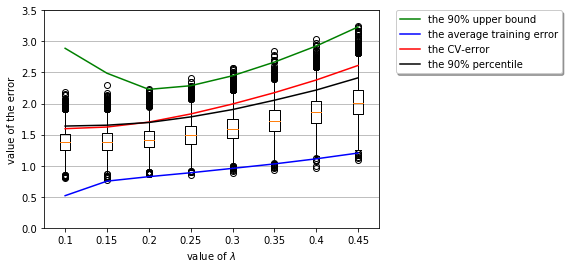

In [10]:
## average test error bounds for the lasso
## total sample size : 100

n3 = 50; test_size_3 = n3; np.random.seed(5) #n3 is the size of each fold

varpi = 0.1; K = 2

n_iter = 64; n_val = 10000; n_dim = 100; n_info = 5; cov_noise = 1

start = 0.1; end = 0.5; step = 0.05; alpha = np.arange(start, end, step)


# generate data

X13, Y13 = data_gen(n3, n_dim, n_info, cov_noise)

X23, Y23 = data_gen(n3, n_dim, n_info, cov_noise)


# training the model
error_matrix_3, upper_array_3, train_array_3, test_array_3, perc_array_3 = error_bounds(X13, Y13, X23, Y23, test_size_3, varpi, 
                                                                              n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)

# plot the figure
error_plot(alpha, error_matrix_3, upper_array_3, train_array_3, test_array_3, perc_array_3, 
           "error_bound_plot_100.pdf")

## Step.10 : the simulation result for $n = 200, p = 100$ 


In the second simulation, we show the result for the 90% upper bound when $n = 200, p = 100$ 

* the data generating process is  $$ y_i = 3 \cdot x_{1,i} + 4 \cdot x_{2,i} + 5 \cdot x_{3,i} + 6 \cdot x_{4,i} + 7 \cdot x_{5,i} + e_i $$

* we set $\varpi = 0.1$, which returns the 90% upper bound

* the size of each fold $n2 = 100$

* "n_val" is the number of the 'pseudo' average test errors for each model. For detail, please see the simulation section of the paper

* we set the sequence of $\lambda$ from $0.1$ to $0.5$, each step is $0.05$. This will return 8 candidate models with different average test errors.

The result is printed after the code

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


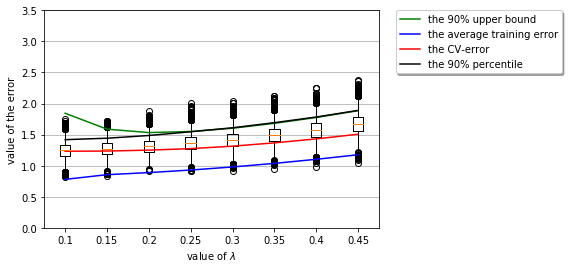

In [11]:
n2 = 100; test_size = n2; np.random.seed(5) #n2 is the size of each fold

# generate data

X12, Y12 = data_gen(n2, n_dim, n_info, cov_noise)

X22, Y22 = data_gen(n2, n_dim, n_info, cov_noise)


# training the model
error_matrix_2, upper_array_2, train_array_2, test_array_2, perc_array_2 = error_bounds(X12, Y12, X22, Y22, test_size, varpi, 
                                                                              n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)

# plot the figure
error_plot(alpha, error_matrix_2, upper_array_2, train_array_2, test_array_2, perc_array_2, 
           "error_bound_plot_200.pdf")

## Step.11 : the simulation result for $n = 400, p = 100$ 

In the third simulation, we show the result for the 90% upper bound when $n = 400, p = 100$ 

* the data generating process is  $$ y_i = 3 \cdot x_{1,i} + 4 \cdot x_{2,i} + 5 \cdot x_{3,i} + 6 \cdot x_{4,i} + 7 \cdot x_{5,i} + e_i $$

* we set $\varpi = 0.1$, which returns the 90% upper bound

* the size of each fold $n_4 = 200$

* "n_val" is the number of the 'pseudo' average test error for each model. For detail, please see the simulation section of the paper

* we set the sequence of $\lambda$ from $0.1$ to $0.5$, each step is $0.05$. This will return 8 candidate models with different average test errors.

The result is attached afer the code

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


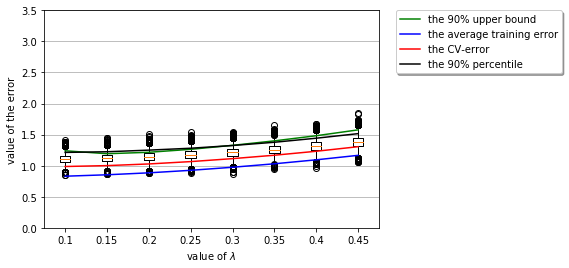

In [12]:
## average test error bounds for the lasso
## total sample size : 400

n4 = 200; test_size_4 = n4; np.random.seed(5) #n4 is the size of each fold

# generate data

X14, Y14 = data_gen(n4, n_dim, n_info, cov_noise)

X24, Y24 = data_gen(n4, n_dim, n_info, cov_noise)


# training the model
error_matrix_4, upper_array_4, train_array_4, test_array_4, perc_array_4 = error_bounds(X14, Y14, X24, Y24, test_size_4, varpi, 
                                                                              n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)

# plot the figure
error_plot(alpha, error_matrix_4, upper_array_4, train_array_4, test_array_4, perc_array_4, 
           "error_bound_plot_400.pdf")